# LegalData Stochastic Optimization Performance Comparison



In [19]:
# Check GPU details if using GPU

!nvidia-smi

import torch
import torch.optim as optim
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/bin/bash: line 1: nvidia-smi: command not found


## Load datasets from google drive.

The datasets can be loaded in any way. This notebook handles them by loading them from Google Drive for convenient use in Google Colab.



In [20]:
from google.colab import drive
import pandas as pd
from torch.utils.data import Dataset
import os

## Mount Google Drive

drive.mount('/content/gdrive/')
os.chdir("/content/gdrive/My Drive/task_folder")

## Get the datasets from Google Drive

train_data = pd.read_csv('abercrombie_train.csv')
test_data =  pd.read_csv('abercrombie_test.csv')

train_data_df=pd.DataFrame(train_data)
test_data_df=pd.DataFrame(test_data)


# from sklearn.model_selection import train_test_split
# full_dataset = train_data_df.append(test_data_df)
# train_data_df, test_data_df = train_test_split(full_dataset, test_size=0.2)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Create the Dataset class for the Abercrombie dataset

In [21]:
## Dataset class to feed into the Dataloader later

class AbercrombieDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        textt = self.data.iloc[index]['text']
        labell = self.data.iloc[index]['answer']

        return {'text':textt, 'label':labell}

## Create the GPT2 collator

In [22]:
# Class that appropriately manages the data, making them a homegeneous batch,
# before feeding them into the GPT2 transformer model

class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = max_sequence_len
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

## Train function

In [23]:
## Train function
def train(dataloader, optimizer_, device_):

  # start_time = time.time()

  predictions_labels = []
  true_labels = []
  total_loss = 0
  train_losses = []

  net.train()

  ## Stochastic Learning Rate Parameters
  c1=0.95
  c2=1.1
  beta=6 # dictates every when the Resetting UMSLR scheme resets

  for i,batch in enumerate(dataloader):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    optimizer_.zero_grad()
    for param_group in optimizer_.param_groups:

        ### UMSLR ####
        # param_group['lr'] *=torch.FloatTensor(1).uniform_(c1**(1/(i+1) ), c2**(1/(i+1 ))).item()

        ### Resetting UMSLR ####
        param_group['lr'] *=torch.FloatTensor(1).uniform_(c1**(1/((i+1)%beta+1) ), c2**(1/((i+1)%beta+1 ))).item()

        ### Default Learning Rate ####
        # param_group['lr']=param_group['lr']

    ## GPT2ForSequenceClassification will be used as the model, which already
    ## incorporates a classifier as its head, therefore its outputs are logits
    outputs = net(**batch)
    loss, logits = outputs[:2]
    total_loss += loss.item()
    loss.backward()
    optimizer.step()

    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)

  # print(time.time()-start_time)

  return true_labels, predictions_labels, avg_epoch_loss, param_group['lr']


## Test function

In [24]:
## Test function

def test(dataloader, device_):

  predictions_labels = []
  true_labels = []
  total_loss = 0
  net.eval()

  # start_time = time.time()

  for i,batch in enumerate(dataloader):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():
        outputs = net(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

  avg_epoch_loss = total_loss / len(dataloader)

  # print(time.time()-start_time)

  return true_labels, predictions_labels, avg_epoch_loss

## Create the data collator and the train/test dataloaders

In [25]:
from torch.utils.data import DataLoader
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification

## The dataloader collator is created

label_encoding = {'generic': 0, 'descriptive': 1, 'suggestive': 2, 'arbitrary':3 , 'fanciful':4 }
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
max_length = 50

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=label_encoding,
                                                          max_sequence_len=max_length)


## The dataloaders are created

batch_size = 1

train_dataset = AbercrombieDataset(train_data_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=gpt2_classificaiton_collator)
print('Created train dataloader with %d batches!'%len(train_dataloader))

test_dataset  =  AbercrombieDataset(test_data_df)
test_dataloader = DataLoader(test_dataset , batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created test dataloader with %d batches!'%len(test_dataloader))

Created train dataloader with 5 batches!
Created test dataloader with 95 batches!


## Construct the GPT2 neural network

In [26]:
## The GPT2 neural net is constructed in this cell and sent to the GPU,
## if one is used

from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification

n_labels = len(label_encoding)

net_config = GPT2Config.from_pretrained('gpt2', num_labels=n_labels)
net = GPT2ForSequenceClassification.from_pretrained('gpt2', config=net_config)

net.resize_token_embeddings(len(tokenizer))
net.config.pad_token_id = net.config.eos_token_id

net.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=5, bias=False)
)

## Results section

In [28]:
## Code that produces the results

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score


train_losses=[]
test_losses=[]

beta1=0.9
beta2=0.999

## Various optimization methods to choose from

optimizer = optim.Adam(net.parameters(),betas=(beta1, beta2), lr=0.0001,amsgrad=True )
# optimizer = optim.AdamW(net.parameters(), betas=(beta1, beta2), lr=0.0001)
# optimizer = optim.Adam(net.parameters(), betas=(beta1, beta2), lr=0.0001, amsgrad=False )
# optimizer = optim.SGD(net.parameters(), lr=0.00001)
# optimizer = optim.SGD(net.parameters(), lr=0.000001, momentum=0.9, nesterov=True)
# optimizer = optim.SGD(net.parameters(), lr=0.000001, momentum=0.9, nesterov=False)


epochs = 40

train_losses = []
test_losses = []
train_accs = []
test_accs = []

## Set the seed for reproduciblity
torch.manual_seed(123)

## Loop through each epoch.
for epoch in tqdm(range(epochs)):
  print('Epoch:',epoch+1)
  running_loss = 0.0
  net.train()

  ## Get train loss and accuracy for epoch
  train_labels, train_predict, train_loss, lr = train(train_dataloader, optimizer, device)
  train_acc = accuracy_score(train_labels, train_predict)

  ## Get train loss and accuracy for epoch
  test_labels, test_predict, test_loss = test(test_dataloader, device)
  test_acc = accuracy_score(test_labels, test_predict)

  # Print loss and accuracy values
  print("train_loss: %.5f - test_loss: %.5f - train_acc: %.5f - test_acc: %.5f \n"%(train_loss, test_loss, train_acc, test_acc))

  # Store losses and accuracy
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1
train_loss: 3.13948 - test_loss: 4.49143 - train_acc: 0.40000 - test_acc: 0.20000 

Epoch: 2
train_loss: 5.08847 - test_loss: 4.16583 - train_acc: 0.20000 - test_acc: 0.20000 

Epoch: 3
train_loss: 3.99448 - test_loss: 3.83743 - train_acc: 0.20000 - test_acc: 0.18947 

Epoch: 4
train_loss: 3.95127 - test_loss: 3.63006 - train_acc: 0.20000 - test_acc: 0.21053 

Epoch: 5
train_loss: 4.06806 - test_loss: 3.46136 - train_acc: 0.20000 - test_acc: 0.29474 

Epoch: 6
train_loss: 1.91008 - test_loss: 3.35635 - train_acc: 0.20000 - test_acc: 0.26316 

Epoch: 7
train_loss: 3.59568 - test_loss: 3.21919 - train_acc: 0.20000 - test_acc: 0.27368 

Epoch: 8
train_loss: 3.75184 - test_loss: 3.04897 - train_acc: 0.20000 - test_acc: 0.25263 

Epoch: 9
train_loss: 3.77321 - test_loss: 2.84943 - train_acc: 0.20000 - test_acc: 0.24211 

Epoch: 10
train_loss: 3.18134 - test_loss: 2.67519 - train_acc: 0.00000 - test_acc: 0.16842 

Epoch: 11
train_loss: 2.37496 - test_loss: 2.49769 - train_acc: 0.200

## Plot the loss and accuracy of the train/test data

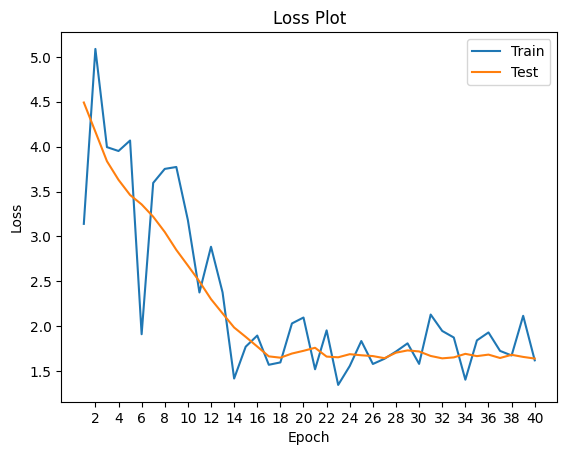

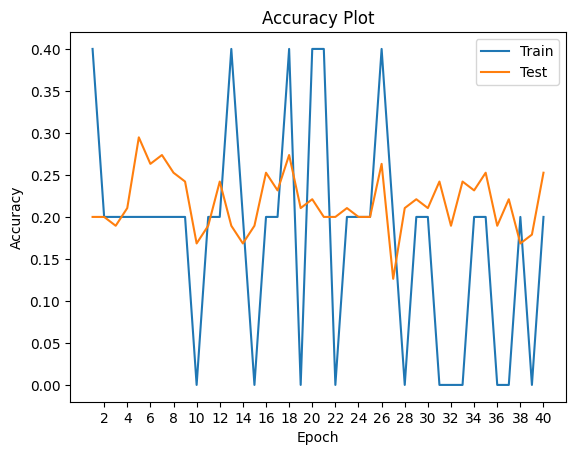

In [32]:
## Helper plotting function

import matplotlib.pyplot as plt
import numpy as np


def plot_losses(train, val, ylabel="Loss", title="Loss Plot"):
    plt.plot(train, label="Train")
    plt.plot(val, label="Test")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Epoch")
    plt.xticks(np.arange(len(train)), np.arange(1, len(train)+1))
    plt.legend()
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.xticks(np.arange(1, 40, 2.0)) # provides xaxis clarity if using 40 epochs
    plt.show()


plot_losses(train_losses, test_losses)
plot_losses(train_accs, test_accs, ylabel="Accuracy", title="Accuracy Plot")

## Obtain the confusion matrix and other metrics

In [31]:
## Besides accuracy, other metrics can be seen here (e.g. recall, F1 etc.) if needed

from sklearn.metrics import classification_report, confusion_matrix

true_labels, predictions_labels, avg_epoch_loss = test(test_dataloader, device)

evaluation_report = classification_report(true_labels, predictions_labels, labels=list(label_encoding.values()), target_names=list(label_encoding.keys()))
print(evaluation_report)

print("Confusion Matrix")
confusion_matrix(true_labels, predictions_labels, labels=list(label_encoding.values()))

              precision    recall  f1-score   support

     generic       0.00      0.00      0.00        19
 descriptive       0.50      0.21      0.30        19
  suggestive       0.08      0.11      0.09        19
   arbitrary       0.31      0.74      0.44        19
    fanciful       0.27      0.21      0.24        19

    accuracy                           0.25        95
   macro avg       0.23      0.25      0.21        95
weighted avg       0.23      0.25      0.21        95

Confusion Matrix


array([[ 0,  2, 13,  3,  1],
       [ 0,  4,  4,  7,  4],
       [ 2,  0,  2, 11,  4],
       [ 0,  0,  3, 14,  2],
       [ 0,  2,  3, 10,  4]])